### 1. Read in the enriched PartB data for year 2013 & 2014

In [1]:
import pandas as pd
import numpy as np
import os 
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
parent = os.path.dirname(os.getcwd())
# df = pd.read_csv(parent + '/Capstone_project/data/year2013_to_2021_combined_with_labels.csv')
df = pd.read_csv(parent + '/Capstone_project/data/year2013_2014_combined_with_labels.csv')
df.fillna(0, inplace=True)

df['Rndrng_Prvdr_Type'] = df['Rndrng_Prvdr_Type'].astype('category').cat.codes
df['Rndrng_Prvdr_Gndr'] = df['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

# df_2015 = df[df.YEAR == 2015]
# df = df[df.YEAR.isin([2013, 2014])]
# df_2015.shape
print(df.shape)

(1847558, 89)
(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)

In [3]:
# split out the holdout data by Rndrng_NPI to avoid data leakage
import random
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

print(train_X.shape, test_X.shape)

(1662708, 86) (184850, 86)


In [4]:
# import random
# random.seed(42)
# holdout_rate = 0.1
# uniq_id = df.Rndrng_NPI.unique()
# holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
# train_set = list(set(uniq_id) - set(holdout_set))

# eval_2015 = list(set(df_2015.Rndrng_NPI.unique()) - set(train_set))
# evalset_2015 = df_2015.query("`Rndrng_NPI` in @eval_2015")
# print(evalset_2015.shape)
# eval_X = evalset_2015.drop(columns=['Rndrng_NPI', 'Fraud_Indicator', 'YEAR'])
# eval_y = evalset_2015.Fraud_Indicator

In [ ]:
# Create the function to visulize the confusion matrix
from sklearn.metrics import roc_auc_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(estimator, test_X, test_y):
    # Create the NumPy array for actual and predicted labels.
    actual    = test_y
    predicted = estimator.predict(test_X)
    # compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)
    # Plot the confusion matrix.
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.ylabel('Actual',fontsize=15)
    plt.xlabel('Prediction',fontsize=15)
    plt.title('Confusion Matrix', fontsize=17)
    return plt.show()

### 3. Plot the confusion matrix for all the stored fitted models

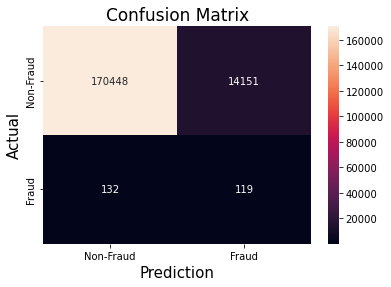

rf_pipe3  - Testset roc-auc evaluation score:  0.8200705916899793


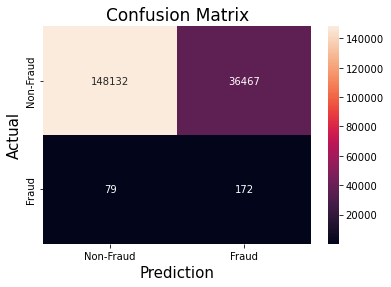

rf_pipe4  - Testset roc-auc evaluation score:  0.8178047888403482


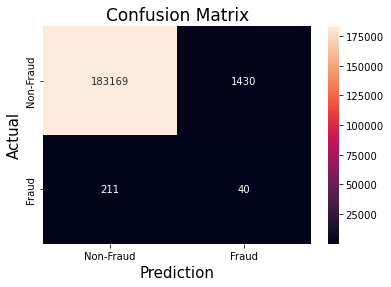

rf_pipe1  - Testset roc-auc evaluation score:  0.8133606776260092


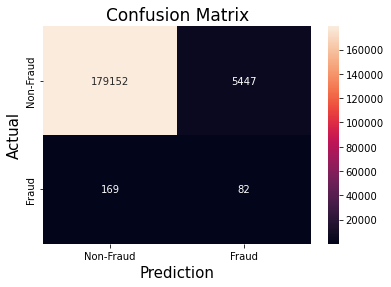

rf_pipe2  - Testset roc-auc evaluation score:  0.81699273469883


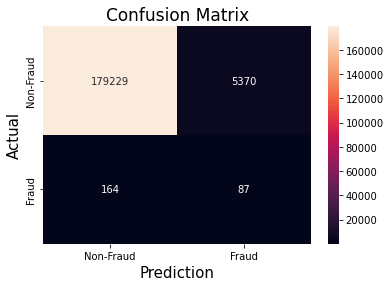

xgb_pipe2  - Testset roc-auc evaluation score:  0.8109000193355473


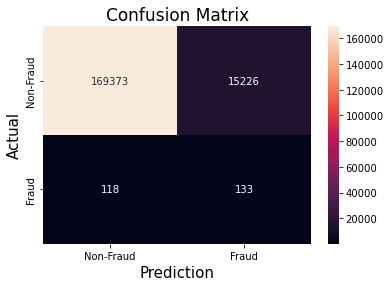

xgb_pipe3  - Testset roc-auc evaluation score:  0.8188997432552684


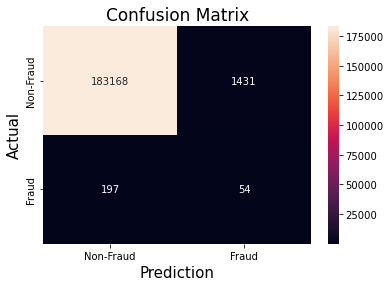

xgb_pipe1  - Testset roc-auc evaluation score:  0.8114728880727342


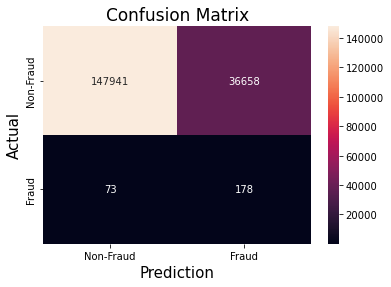

xgb_pipe4  - Testset roc-auc evaluation score:  0.8215624007148563


In [10]:
import glob
import cloudpickle
import re
path = parent + '/Capstone_project'
cloudpickle_files = glob.glob(os.path.join(path, "rf_pipe*.cloudpickle")) + \
                    glob.glob(os.path.join(path, "xgb_pipe*.cloudpickle"))
eval_X = test_X
eval_y = test_y
all_pipe_fitted = []
for cpk in cloudpickle_files:
    cpkpipe = cloudpickle.load(open(cpk, 'rb'))
    all_pipe_fitted.append(cpkpipe)
    eval_score = roc_auc_score(eval_y, cpkpipe.predict_proba(eval_X)[:, 1])
    plot_confusion_matrix(cpkpipe, eval_X, eval_y)
    print(cpk.split('/')[-1].split('.')[0], ' - Testset roc-auc evaluation score: ', eval_score)

In [16]:
xgb_pipe4 = all_pipe_fitted[-1]
xgb_pipe4.named_steps

{'under': RandomUnderSampler(random_state=42, sampling_strategy=1),
 'scaler': StandardScaler(),
 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.8, colsample_bynode=None,
               colsample_bytree=0.8, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.02, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=20, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...)}

### 5. Visualize the SHAP features contribution

In [ ]:
import shap

#load JS vis in the notebook
shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(xgb_pipe4.named_steps['xgb'])

#apply the preprocessing to x_test
observations = xgb_pipe4['scaler'].transform(eval_X)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, eval_X, max_display=10, plot_type="bar")